In [1]:
from torch import distributions
import csv
import pandas as pd
import datetime
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions
import matplotlib.pyplot as plt
import numpy as np

import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [2]:
df = pd.read_pickle('/content/drive/My Drive/DL_Project/finalDF.pkl')
#Shuffle Dataframe
df = df.sample(frac=1).reset_index(drop=True)
print(len(df))
#Split out shuffled dataframe into training and test data
trainSize = int(0.8*len(df))
validationSize = int(0.1*len(df))
testSize = len(df) - trainSize - validationSize
trainDF = df.iloc[:trainSize]
tempDF = df.iloc[(trainSize+1):]
validationDF = tempDF.iloc[:validationSize]
testDF = df.iloc[(trainSize+2+validationSize):]
print(df)
print(trainSize, validationSize, testSize)
print(trainDF)
print(validationDF)
print(testDF)

182253
        gameNumber  ...  dayNightIndicator_N
0                2  ...                    1
1                0  ...                    1
2                0  ...                    1
3                0  ...                    1
4                0  ...                    1
...            ...  ...                  ...
182248           0  ...                    0
182249           0  ...                    1
182250           0  ...                    1
182251           0  ...                    0
182252           0  ...                    0

[182253 rows x 387 columns]
145802 18225 18226
        gameNumber  ...  dayNightIndicator_N
0                2  ...                    1
1                0  ...                    1
2                0  ...                    1
3                0  ...                    1
4                0  ...                    1
...            ...  ...                  ...
145797           0  ...                    1
145798           0  ...                    0


In [3]:
targetHeaders = ['visitingTeamScore','homeTeamScore']
trainTargetTensor = torch.tensor(trainDF[targetHeaders].values.astype(np.float32))
trainFeatureTensor = torch.tensor(trainDF.drop(targetHeaders,axis=1).values.astype(np.float32))
validTargetTensor = torch.tensor(validationDF[targetHeaders].values.astype(np.float32))
validFeatureTensor = torch.tensor(validationDF.drop(targetHeaders,axis=1).values.astype(np.float32))
testTargetTensor = torch.tensor(testDF[targetHeaders].values.astype(np.float32))
testFeatureTensor = torch.tensor(testDF.drop(targetHeaders,axis=1).values.astype(np.float32))

In [4]:
#Split into training, test and validation data
#Remember that we shuffled the dataframe and divided it already
trainDataset = TensorDataset(trainFeatureTensor, trainTargetTensor)
testDataset = TensorDataset(testFeatureTensor, testTargetTensor)
validDataset = TensorDataset(validFeatureTensor, validTargetTensor)

In [5]:
#Training dataloader
batchSize = 64
trainDataLoader = DataLoader(trainDataset, batch_size = batchSize, shuffle = True)
testDataLoader = DataLoader(testDataset, batch_size = batchSize, shuffle = True)
validDataLoader = DataLoader(validDataset, batch_size = batchSize, shuffle = True)

In [6]:
print(len(trainDataset))

145802


In [7]:
#Set up model
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.layer = nn.Sequential(
        nn.BatchNorm1d(num_features=385),
        nn.Linear(in_features = 385, out_features=300),
        nn.BatchNorm1d(num_features=300),
        nn.ReLU(),
        nn.Linear(in_features = 300, out_features=150),
        nn.BatchNorm1d(num_features=150),
        nn.ReLU(),
        nn.Linear(in_features = 150, out_features=75),
        nn.BatchNorm1d(num_features=75),
        nn.ReLU(),
        nn.Linear(in_features = 75, out_features=40),
        nn.BatchNorm1d(num_features=40),
        nn.ReLU(),
        nn.Linear(in_features = 40, out_features=20),
        nn.BatchNorm1d(num_features=20),
        nn.ReLU(),
        nn.Linear(in_features = 20, out_features=10),
        nn.BatchNorm1d(num_features=10),
        nn.ReLU(),
        nn.Linear(in_features = 10, out_features=5),
        nn.BatchNorm1d(num_features=5),
        nn.ReLU(),
        nn.Linear(in_features = 5, out_features=2),
     )
  def forward(self, input):
    x = self.layer(input)
    return x
#Send to GPU
neuralNet = Model().cuda()


In [8]:
#Used MSE loss because we dont care if it over or underguesses, both are equally bad
criterion = torch.nn.MSELoss()
opt = torch.optim.SGD(neuralNet.parameters(), lr=0.001)

In [9]:
#Training
numEpochs = 200
trainLossList = []
validLossList = []

trainSpotOnHistory = []
validSpotOnHistory = []
trainMissCountHistory = []
validMissCountHistory = []
trainRunsOffHistory = []
validRunsOffHistory = []
trainSpotPercentHistory = []
validSpotPercentHistory = []



for epoch in range(numEpochs):
  totalTrainPredictionList = []
  totalTrainScoreList = []
  totalValidPredictionList = []
  totalValidScoreList = []
  trainLoss = 0.0
  validLoss = 0.0
  for i, data in enumerate(trainDataLoader):
    gameInfo, scores = data
    gameInfo = gameInfo.cuda()
    scores = scores.cuda()
    opt.zero_grad()
    prediction = neuralNet(gameInfo)
    predictionRound = torch.round(prediction)
    
    #Putting results in a list to parse out exactly what happened
    predList = predictionRound.tolist()
    scoreList = scores.tolist()
    for l in predList: totalTrainPredictionList.append(l)
    for l in scoreList: totalTrainScoreList.append(l)


    result = criterion(prediction, scores)
    result.backward()
    opt.step()
    trainLoss += result.item()
  for i, data in enumerate(validDataLoader):
    with torch.no_grad():
      gameInfo, scores = data
      gameInfo = gameInfo.cuda()
      scores = scores.cuda()
      prediction = neuralNet(gameInfo)

      predictionRound = torch.round(prediction)
    
      #Putting results in a list to parse out exactly what happened
      predList = predictionRound.tolist()
      scoreList = scores.tolist()
      for l in predList: totalValidPredictionList.append(l)
      for l in scoreList: totalValidScoreList.append(l)

      result = criterion(prediction, scores)
      validLoss += result.item()

  trainLoss = trainLoss / len(trainDataLoader)
  validLoss = validLoss / len(validDataLoader)
  trainLossList.append(trainLoss)
  validLossList.append(validLoss)

  #Parse losses for training data
  trainspotOn = 0
  trainmissCount = 0  
  trainRunLoss = []
  for i in range(len(totalTrainPredictionList)):
      tl = 0
      tl += abs(totalTrainPredictionList[i][0]-totalTrainScoreList[i][0])
      tl += abs(totalTrainPredictionList[i][1]-totalTrainScoreList[i][1])
      if tl == 0: 
        trainspotOn += 1
      else:
        trainmissCount += 1
      trainRunLoss.append(tl)


  #Parse losses for validation data
  validspotOn = 0
  validmissCount = 0  
  validRunLoss = []
  for i in range(len(totalValidPredictionList)):
      tl = 0
      tl += abs(totalValidPredictionList[i][0]-totalValidScoreList[i][0])
      tl += abs(totalValidPredictionList[i][1]-totalValidScoreList[i][1])
      if tl == 0: 
        validspotOn += 1
      else:
        validmissCount += 1
      validRunLoss.append(tl)
    
  #Append records for a history over EPOCH's
  trainSpotOnHistory.append(trainspotOn)
  validSpotOnHistory.append(validspotOn)
  trainMissCountHistory.append(trainmissCount)
  validMissCountHistory.append(validmissCount)
  trainRunsOffHistory.append(sum(trainRunLoss)/trainmissCount)
  validRunsOffHistory.append(sum(validRunLoss)/validmissCount)
  trainSpotPercentHistory.append(100*(trainspotOn/len(totalTrainPredictionList)))
  validSpotPercentHistory.append(100*(validspotOn/len(totalValidPredictionList)))
  
  # print('EPOCH %s, train loss %s, validation loss %s' %(epoch, trainLoss, validLoss))
  print('---------------------EPOCH %s---------------------' %(epoch))
  print('TRAINING')
  print('Number of games predicted perfectly: %s' %(trainspotOn))
  print('Number of games predicted incorrectly: %s' %(trainmissCount))
  print('Percentage of games predicted perfectly: %s' %(100*(trainspotOn/len(totalTrainPredictionList))))
  print('Average number of runs off in a miss: %s' %(sum(trainRunLoss)/trainmissCount))
  print('VALIDATION')
  print('Number of games predicted perfectly: %s' %(validspotOn))
  print('Number of games predicted incorrectly: %s' %(validmissCount))
  print('Percentage of games predicted perfectly: %s' %(100*(validspotOn/len(totalValidPredictionList))))
  print('Average number of runs off in a miss: %s' %(sum(validRunLoss)/validmissCount))
  print("---------------------------------------------------")
  print(" ")





---------------------EPOCH 0---------------------
TRAINING
Number of games predicted perfectly: 19992
Number of games predicted incorrectly: 125810
Percentage of games predicted perfectly: 13.71174606658345
Average number of runs off in a miss: 2.7172879739289404
VALIDATION
Number of games predicted perfectly: 4424
Number of games predicted incorrectly: 13801
Percentage of games predicted perfectly: 24.27434842249657
Average number of runs off in a miss: 1.5705383667850157
---------------------------------------------------
 
---------------------EPOCH 1---------------------
TRAINING
Number of games predicted perfectly: 40109
Number of games predicted incorrectly: 105693
Percentage of games predicted perfectly: 27.50922483916544
Average number of runs off in a miss: 1.5233648396771782
VALIDATION
Number of games predicted perfectly: 5438
Number of games predicted incorrectly: 12787
Percentage of games predicted perfectly: 29.838134430727024
Average number of runs off in a miss: 1.495112

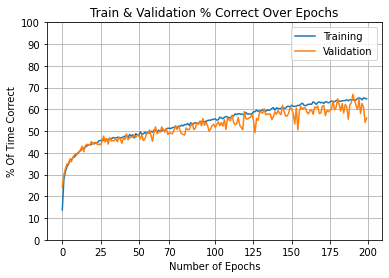

In [13]:
plt.plot(trainSpotPercentHistory, label='Training')
plt.plot(validSpotPercentHistory,label='Validation')
plt.xlabel("Number of Epochs")
plt.ylabel("% Of Time Correct")
plt.legend()
plt.title("Train & Validation % Correct Over Epochs")
plt.xticks([0,25,50,70,100,125,150,175,200])
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.grid()
plt.show()

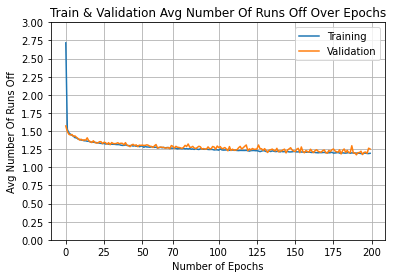

In [14]:
plt.plot(trainRunsOffHistory, label='Training')
plt.plot(validRunsOffHistory, label='Validation')
plt.xlabel("Number of Epochs")
plt.ylabel("Avg Number Of Runs Off")
plt.legend()
plt.title("Train & Validation Avg Number Of Runs Off Over Epochs")
plt.xticks([0,25,50,70,100,125,150,175,200])
plt.yticks([0,.25,.5,.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3])
plt.grid()
plt.show()

In [12]:
#Testing
#Here we round the data to the nearest whole number, giving the official guess
testLossList = []
testLoss = 0
totalPredictionList = []
totalScoreList = []
for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      gameInfo, scores = data
      gameInfo = gameInfo.cuda()
      scores = scores.cuda()
      prediction = neuralNet(gameInfo)
      predictionRound = torch.round(prediction)
      
      #Putting results in a list to parse out exactly what happened
      predList = predictionRound.tolist()
      scoreList = scores.tolist()
      for l in predList: totalPredictionList.append(l)
      for l in scoreList: totalScoreList.append(l)
      result = criterion(prediction, scores)
      testLoss += result.item()
    testLoss = testLoss / len(testDataLoader)
    testLossList.append(testLoss)

spotOn = 0
missCount = 0  
runLoss = []
for i in range(len(totalPredictionList)):
    tl = 0
    tl += abs(totalPredictionList[i][0]-totalScoreList[i][0])
    tl += abs(totalPredictionList[i][1]-totalScoreList[i][1])
    if tl == 0: 
      spotOn += 1
    else:
      missCount += 1
    runLoss.append(tl)

print('Number of games predicted perfectly: %s' %(spotOn))
print('Number of games predicted incorrectly: %s' %(missCount))
print('Percentage of games predicted perfectly: %s' %(100*(spotOn/len(totalPredictionList))))
print('Average number of runs off in a miss: %s' %(sum(runLoss)/missCount))



Number of games predicted perfectly: 10530
Number of games predicted incorrectly: 7694
Percentage of games predicted perfectly: 57.780948200175594
Average number of runs off in a miss: 1.2544840135170263


Code Sources

I used our first homework as an outline for a general structure and then made all of my modifications from that basic framework.

I used the resnet paper described in my writeup as the instpiration for my ResNet but I didn't use any code from that paper.  I came up with that myself.

Getting the data from a df to a proper torch dataset / tensor:
https://stackoverflow.com/questions/41924453/pytorch-how-to-use-dataloaders-for-custom-datasets